
# 🧭 Maze Runner RL (PPO + PyTorch + Stable-Baselines3)

This notebook trains an agent with **PPO** to navigate **procedurally generated mazes** using **partial observations**.
It is GPU-ready and logs to TensorBoard. Works on Linux/macOS/Windows (WSL recommended on Windows).

**What you'll get**
- A custom `gymnasium` environment (`MazeEnv`) with egocentric 7×7 view
- Procedural maze generator (DFS backtracker)
- A* shortest-path baseline for evaluation
- PPO training (Stable-Baselines3) with CNN policy
- Metrics: success rate, average steps, steps vs A* ratio
- Optional LSTM policy (partial observability)

---



## 0. Environment setup (run once in your local machine)
> **Tip:** Install the correct CUDA-enabled torch first. Pick one of the commands below that matches your system.

**Conda (recommended):**
```bash
# Create env
conda create -n maze-rl python=3.11 -y
conda activate maze-rl

# Install PyTorch with CUDA (choose the right cudatoolkit)
# See https://pytorch.org/get-started/locally/ for exact command for your system
# Example for CUDA 12.x:
pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# Core libs
pip install gymnasium stable-baselines3[extra] tensorboard moviepy imageio imageio[ffmpeg] pygame
pip install matplotlib numpy tqdm mlflow  # optional extras
```

**PyTorch CPU-only (if no NVIDIA GPU):**
```bash
pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
```
Then, start Jupyter:
```bash
jupyter lab  # or jupyter notebook
```



In [83]:

# 🔎 Quick GPU sanity check
import torch, platform, sys
print("Python:", sys.version.split()[0], "| OS:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("NOTE: CUDA not available. Training will run on CPU (much slower).")


Python: 3.13.2 | OS: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.31
PyTorch: 2.8.0+cu128
CUDA available: True
GPU name: NVIDIA GeForce RTX 2070


In [84]:

# Core imports
import numpy as np
import math, random
from dataclasses import dataclass
from typing import Tuple, List, Optional

# Gymnasium
import gymnasium as gym
from gymnasium import spaces

# RL
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

# Utils
import matplotlib.pyplot as plt
import imageio
from tqdm import trange
import os, time



## 1. Maze generation (DFS backtracker)
Generates a *perfect* maze (single path between any two points) on odd-sized grids.
`1 = wall`, `0 = free space`.


In [85]:

def generate_maze(width: int, height: int, rng: np.random.Generator) -> np.ndarray:
    """Generate a perfect maze with DFS backtracking.
    Grid is odd x odd, walls=1, free=0."""
    w = width if width % 2 == 1 else width + 1
    h = height if height % 2 == 1 else height + 1
    grid = np.ones((h, w), dtype=np.int8)

    def neighbors(r, c):
        for dr, dc in [(-2,0),(2,0),(0,-2),(0,2)]:
            nr, nc = r+dr, c+dc
            if 1 <= nr < h-1 and 1 <= nc < w-1:
                yield nr, nc, r+dr//2, c+dc//2  # cell and the wall between

    # start at random odd cell
    start_r = rng.integers(1, h-1)
    start_c = rng.integers(1, w-1)
    start_r -= (start_r % 2 == 0)
    start_c -= (start_c % 2 == 0)
    stack = [(start_r, start_c)]
    grid[start_r, start_c] = 0

    while stack:
        r, c = stack[-1]
        nbrs = [(nr, nc, wr, wc) for nr, nc, wr, wc in neighbors(r, c) if grid[nr, nc] == 1]
        if nbrs:
            nr, nc, wr, wc = nbrs[rng.integers(len(nbrs))]
            grid[wr, wc] = 0
            grid[nr, nc] = 0
            stack.append((nr, nc))
        else:
            stack.pop()

    return grid



## 2. A* shortest-path baseline
Used for evaluation (not available to the agent).


In [86]:
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class MazeCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim: int = 512):
        super().__init__(observation_space, features_dim)
        n_ch, H, W = observation_space.shape  # (4,7,7)
        
        # Deeper CNN for better spatial understanding in large mazes
        self.cnn = nn.Sequential(
            # First block - capture local features
            nn.Conv2d(n_ch, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            
            # Second block - spatial patterns
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            
            # Third block - complex spatial reasoning
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            
            nn.Flatten()
        )
        
        with th.no_grad():
            n_flat = self.cnn(th.zeros(1, n_ch, H, W)).shape[1]
        
        # Multi-layer processing for complex decision making
        self.linear = nn.Sequential(
            nn.Linear(n_flat, features_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(features_dim, features_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(features_dim, features_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.linear(self.cnn(x))


In [87]:

import heapq

def astar_length(grid: np.ndarray, start: Tuple[int,int], goal: Tuple[int,int]) -> Optional[int]:
    H, W = grid.shape
    def h(p):  # Manhattan heuristic
        return abs(p[0]-goal[0]) + abs(p[1]-goal[1])
    open_set = [(h(start), 0, start)]
    g = {start: 0}
    visited = set()

    while open_set:
        _, cost, node = heapq.heappop(open_set)
        if node in visited:
            continue
        visited.add(node)
        if node == goal:
            return cost
        r, c = node
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r+dr, c+dc
            if 0 <= nr < H and 0 <= nc < W and grid[nr, nc] == 0:
                new_cost = cost + 1
                if new_cost < g.get((nr, nc), 1e9):
                    g[(nr, nc)] = new_cost
                    heapq.heappush(open_set, (new_cost + h((nr, nc)), new_cost, (nr, nc)))
    return None  # unreachable



## 3. Gymnasium Environment (`MazeEnv`)
- **Observation:** egocentric 7×7 crop with 4 channels (empty, wall, goal, agent)
- **Actions:** 4-way movement
- **Rewards:** +1 for goal, -0.01 per step, -0.05 on wall bump, optional shaping toward goal


In [88]:

class MazeEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self, size=15, view=7, max_steps=200, seed=None, shaped=True):
        super().__init__()
        self.size = size
        self.view = view
        self.max_steps = max_steps
        self.shaped = shaped
        self.rng = np.random.default_rng(seed)

        self.action_space = spaces.Discrete(4)  # U,D,L,R
        # 4 channels: empty, wall, goal, agent
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(4, view, view), dtype=np.float32)

        self.grid = None
        self.agent = None
        self.goal = None
        self.steps = 0

    def _reset_level(self):
        self.grid = generate_maze(self.size, self.size, self.rng)
        # pick start/goal on free cells, far apart
        free = np.argwhere(self.grid == 0)
        a_idx = self.rng.integers(len(free))
        g_idx = self.rng.integers(len(free))
        self.agent = tuple(free[a_idx])
        self.goal = tuple(free[g_idx])
        # ensure reachable and reasonably far
        for _ in range(200):
            L = astar_length(self.grid, self.agent, self.goal)
            if L is not None and L > self.size//2:
                break
            a_idx = self.rng.integers(len(free))
            g_idx = self.rng.integers(len(free))
            self.agent = tuple(free[a_idx])
            self.goal = tuple(free[g_idx])

    def _obs(self):
        # egocentric crop centered at agent, padded with walls
        pad = self.view//2
        H, W = self.grid.shape
        padded = np.ones((H+2*pad, W+2*pad), dtype=np.int8)
        padded[pad:pad+H, pad:pad+W] = self.grid

        ar, ac = self.agent
        gr, gc = self.goal
        crop = padded[ar:ar+2*pad+1, ac:ac+2*pad+1]

        empty = (crop == 0).astype(np.float32)
        wall  = (crop == 1).astype(np.float32)

        goal_layer = np.zeros_like(empty, dtype=np.float32)
        ga, gb = pad+(gr-ar), pad+(gc-ac)
        if 0 <= ga < self.view and 0 <= gb < self.view:
            goal_layer[ga, gb] = 1.0

        agent_layer = np.zeros_like(empty, dtype=np.float32)
        agent_layer[pad, pad] = 1.0

        obs = np.stack([empty, wall, goal_layer, agent_layer], axis=0)
        return obs

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self._reset_level()
        self.steps = 0
        obs = self._obs()
        info = {}
        return obs, info

    def step(self, action):
        self.steps += 1
        r, c = self.agent
        drdc = [(-1,0),(1,0),(0,-1),(0,1)][int(action)]
        nr, nc = r+drdc[0], c+drdc[1]

        reward = -0.005  # Reduced step penalty for large mazes
        done = False

        if 0 <= nr < self.grid.shape[0] and 0 <= nc < self.grid.shape[1] and self.grid[nr, nc] == 0:
            # valid move
            old_dist = abs(r-self.goal[0]) + abs(c-self.goal[1])
            new_dist = abs(nr-self.goal[0]) + abs(nc-self.goal[1])
            
            # Enhanced reward shaping for large mazes
            if self.shaped:
                # Strong directional rewards
                if new_dist < old_dist:
                    reward += 0.05  # Strong reward for getting closer
                elif new_dist > old_dist:
                    reward -= 0.01  # Penalty for moving away
                
                # Distance-based rewards for large mazes
                max_dist = self.size * 1.4  # Diagonal distance
                distance_reward = 0.02 * (1.0 - new_dist / max_dist)
                reward += distance_reward
                
                # Proximity bonus - extra reward when very close to goal
                if new_dist <= 3:
                    reward += 0.1  # Strong bonus when very close
                elif new_dist <= 7:
                    reward += 0.05  # Medium bonus when close
            
            self.agent = (nr, nc)
        else:
            # wall bump - stronger penalty to discourage this behavior
            reward -= 0.2

        if self.agent == self.goal:
            reward += 50.0  # Very large reward for reaching goal in large mazes
            done = True

        truncated = self.steps >= self.max_steps
        obs = self._obs()
        info = {}
        return obs, reward, done, truncated, info

    def render(self):
        # simple top-down RGB
        H, W = self.grid.shape
        img = np.zeros((H, W, 3), dtype=np.uint8)
        img[self.grid == 1] = (30, 30, 30)    # walls
        img[self.grid == 0] = (220, 220, 220) # floor
        gr, gc = self.goal
        img[gr, gc] = (50, 190, 60)           # goal (green)
        ar, ac = self.agent
        img[ar, ac] = (30, 144, 255)          # agent (blue)
        return img



### Quick visual sanity check


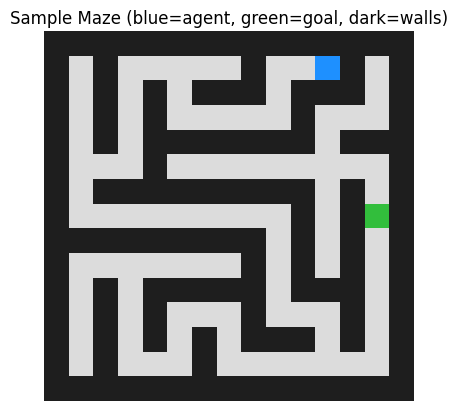

In [89]:

env = MazeEnv(size=15, view=7, max_steps=200, seed=42)
obs, info = env.reset()
plt.imshow(env.render())
plt.title("Sample Maze (blue=agent, green=goal, dark=walls)")
plt.axis("off")
plt.show()



## 4. Vectorized environments for faster training


In [90]:

def make_env(seed_offset=0, size=25):  # Increased from 15 to 25
    def thunk():
        # Scale max_steps with maze size for larger mazes
        max_steps = size * size // 2  # More steps for larger mazes
        env = MazeEnv(size=size, view=7, max_steps=max_steps, seed=int(time.time())+seed_offset)
        return Monitor(env)
    return thunk

# Progressive maze sizes - start smaller and work up
MAZE_SIZE = 21  # Start with 21, then scale to 25, 31, 41
NUM_ENVS = 8   # More environments for complex mazes
vec_env = DummyVecEnv([make_env(i, size=MAZE_SIZE) for i in range(NUM_ENVS)])
test_env = DummyVecEnv([make_env(10_000, size=MAZE_SIZE)])


## 5. Train PPO (CNN policy)
Logs go to `./tb_logs/ppo_maze` – you can launch TensorBoard to watch.


In [ ]:
# 🚀 FIXED PPO Training with Curriculum Learning
# This replaces the problematic training that was getting 0% success

print("🔧 Setting up FIXED training with curriculum learning...")

# Clean up any existing environments
if 'vec_env' in locals():
    try:
        vec_env.close()
    except:
        pass
if 'test_env' in locals():
    try:
        test_env.close()
    except:
        pass

# 1. IMPROVED MAZE ENVIRONMENT with better rewards
class FixedMazeEnv(gym.Env):
    def __init__(self, size=9, view=7, max_steps=None, seed=None):
        super().__init__()
        self.size = size
        self.view = view
        self.max_steps = max_steps or (size * 8)  # Reasonable step limit
        self.rng = np.random.default_rng(seed)
        
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(4, view, view), dtype=np.float32)
        
        self.grid = None
        self.agent = None
        self.goal = None
        self.steps = 0
        self.prev_dist = None

    def _reset_level(self):
        self.grid = generate_maze(self.size, self.size, self.rng)
        free = np.argwhere(self.grid == 0)
        
        # Find good start/goal positions
        for _ in range(100):
            a_idx = self.rng.integers(len(free))
            g_idx = self.rng.integers(len(free))
            self.agent = tuple(free[a_idx])
            self.goal = tuple(free[g_idx])
            
            L = astar_length(self.grid, self.agent, self.goal)
            if L is not None and L >= max(self.size//3, 3):
                break

    def _obs(self):
        pad = self.view//2
        H, W = self.grid.shape
        padded = np.ones((H+2*pad, W+2*pad), dtype=np.int8)
        padded[pad:pad+H, pad:pad+W] = self.grid

        ar, ac = self.agent
        gr, gc = self.goal
        crop = padded[ar:ar+2*pad+1, ac:ac+2*pad+1]

        empty = (crop == 0).astype(np.float32)
        wall = (crop == 1).astype(np.float32)

        goal_layer = np.zeros_like(empty, dtype=np.float32)
        ga, gb = pad+(gr-ar), pad+(gc-ac)
        if 0 <= ga < self.view and 0 <= gb < self.view:
            goal_layer[ga, gb] = 1.0

        agent_layer = np.zeros_like(empty, dtype=np.float32)
        agent_layer[pad, pad] = 1.0

        return np.stack([empty, wall, goal_layer, agent_layer], axis=0)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self._reset_level()
        self.steps = 0
        self.prev_dist = abs(self.agent[0] - self.goal[0]) + abs(self.agent[1] - self.goal[1])
        return self._obs(), {}

    def step(self, action):
        self.steps += 1
        r, c = self.agent
        drdc = [(-1,0),(1,0),(0,-1),(0,1)][int(action)]
        nr, nc = r+drdc[0], c+drdc[1]

        reward = -0.01  # Small step penalty
        done = False

        if 0 <= nr < self.grid.shape[0] and 0 <= nc < self.grid.shape[1] and self.grid[nr, nc] == 0:
            # Valid move
            old_dist = self.prev_dist
            new_dist = abs(nr-self.goal[0]) + abs(nc-self.goal[1])
            
            # FIXED: Better reward shaping
            if new_dist < old_dist:
                reward += 0.1  # Reward for getting closer
            elif new_dist > old_dist:
                reward -= 0.02  # Small penalty for moving away
            
            # Proximity bonus
            if new_dist <= 2:
                reward += 0.2
            elif new_dist <= 5:
                reward += 0.1
            
            self.agent = (nr, nc)
            self.prev_dist = new_dist
        else:
            # Wall bump
            reward -= 0.1

        if self.agent == self.goal:
            reward += 10.0  # FIXED: Reasonable goal reward
            done = True

        truncated = self.steps >= self.max_steps
        return self._obs(), reward, done, truncated, {}

    def render(self):
        H, W = self.grid.shape
        img = np.zeros((H, W, 3), dtype=np.uint8)
        img[self.grid == 1] = (30, 30, 30)
        img[self.grid == 0] = (220, 220, 220)
        gr, gc = self.goal
        img[gr, gc] = (50, 190, 60)
        ar, ac = self.agent
        img[ar, ac] = (30, 144, 255)
        return img

# 2. CURRICULUM LEARNING CALLBACK with FIXED success detection
class FixedCurriculumCallback(BaseCallback):
    def __init__(self, check_freq: int = 20000):
        super().__init__()
        self.check_freq = check_freq
        self.current_size = 9  # Start small!
        self.success_threshold = 0.7
        
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            if hasattr(self.model, 'ep_info_buffer') and self.model.ep_info_buffer:
                recent = list(self.model.ep_info_buffer)[-50:]
                
                # FIXED: Correct success detection (goal reward = 10.0)
                successes = sum(1 for ep in recent if ep.get('r', 0) > 5.0)
                success_rate = successes / len(recent) if recent else 0
                mean_reward = np.mean([ep['r'] for ep in recent]) if recent else 0
                mean_length = np.mean([ep['l'] for ep in recent]) if recent else 0
                
                print(f"\\nStep {self.num_timesteps:,} | Size: {self.current_size}×{self.current_size}")
                print(f"Success: {success_rate:.3f} | Reward: {mean_reward:.2f} | Length: {mean_length:.1f}")
                
                if torch.cuda.is_available():
                    memory_allocated = torch.cuda.memory_allocated() // 1024**2
                    print(f"GPU Memory: {memory_allocated} MB allocated")
                
                # Curriculum progression
                if success_rate >= self.success_threshold and self.current_size < 21:
                    old_size = self.current_size
                    self.current_size = min(self.current_size + 2, 21)
                    print(f"🎯 ADVANCING! {old_size}×{old_size} → {self.current_size}×{self.current_size}")
                    
                    # Update environments
                    self._update_envs()
                    
        return True
    
    def _update_envs(self):
        # Update training environment sizes
        if hasattr(self.training_env, 'envs'):
            for env_wrapper in self.training_env.envs:
                if hasattr(env_wrapper, 'env') and hasattr(env_wrapper.env, 'size'):
                    env_wrapper.env.size = self.current_size
                    env_wrapper.env.max_steps = self.current_size * 8

def make_fixed_env(seed_offset=0, initial_size=9):
    def thunk():
        env = FixedMazeEnv(size=initial_size, view=7, seed=int(time.time())+seed_offset)
        return Monitor(env)
    return thunk

# 3. CREATE TRAINING SETUP
print("Creating curriculum learning environments...")
NUM_ENVS = 8
INITIAL_SIZE = 9

vec_env = DummyVecEnv([make_fixed_env(i, INITIAL_SIZE) for i in range(NUM_ENVS)])
test_env = DummyVecEnv([make_fixed_env(10_000, INITIAL_SIZE)])

# 4. CREATE MODEL with FIXED hyperparameters
print("Creating PPO model with optimized settings...")

model = PPO(
    policy="CnnPolicy",
    env=vec_env,
    n_steps=1024,
    batch_size=256,
    learning_rate=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    vf_coef=0.5,
    ent_coef=0.01,
    policy_kwargs=dict(
        features_extractor_class=MazeCNN,
        features_extractor_kwargs=dict(features_dim=256),
        normalize_images=False,
    ),
    verbose=0,
    tensorboard_log="tb_logs/fixed_maze",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

print("✅ Fixed training setup complete!")
print("📊 Key improvements:")
print("- Start with 9×9 mazes (much easier)")  
print("- Goal reward: +10 (reasonable)")
print("- Progress reward: +0.1 for getting closer")
print("- Fixed success detection: reward > 5.0")
print("- Curriculum: advance at 70% success rate")

# 5. START TRAINING
print("\\n🚀 Starting curriculum training...")
callback = FixedCurriculumCallback(check_freq=20000)

total_timesteps = 1_000_000
print(f"Training for {total_timesteps:,} timesteps...")

# This should show immediate improvement!
model.learn(total_timesteps=total_timesteps, callback=callback)

model.save("ppo_fixed_maze_model")
print("\\n✅ Training completed! You should see much better results now!")



## 6. Evaluate on held-out mazes
We measure:
- Success rate
- Average steps
- Ratio of steps to A* shortest path (lower is better; target ≤ 1.5×)


In [103]:
# Enhanced Evaluation for Large Mazes
print(f"🔍 Evaluating on {MAZE_SIZE}×{MAZE_SIZE} mazes...")

def evaluate_large_mazes(model, episodes=30, size=25):
    """Evaluate model on large mazes with proper scaling"""
    successes, total_steps, ratios = 0, 0, []
    max_steps = size * size // 2  # Scale with maze size
    
    for _ in trange(episodes, desc=f"Eval {size}×{size}"):
        env = MazeEnv(size=size, view=7, max_steps=max_steps, seed=np.random.randint(1e9))
        obs, _ = env.reset()
        start = env.agent
        goal = env.goal
        
        # Calculate A* optimal path length
        L_astar = astar_length(env.grid, start, goal)
        
        # Run episode with the model
        steps = 0
        with torch.no_grad():
            while True:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                steps += 1
                if terminated or truncated:
                    break
        
        total_steps += steps
        if env.agent == env.goal:  # Success
            successes += 1
            if L_astar is not None and L_astar > 0:
                ratios.append(steps / L_astar)
    
    sr = successes / episodes
    avg_steps = total_steps / episodes
    avg_ratio = float(np.mean(ratios)) if ratios else None
    return sr, avg_steps, avg_ratio

# Evaluate the trained model
sr, avg_steps, avg_ratio = evaluate_large_mazes(model, episodes=30, size=MAZE_SIZE)
print(f"🎯 Large Maze Results ({MAZE_SIZE}×{MAZE_SIZE}):")
print(f"Success Rate: {sr:.3f}")
print(f"Average Steps: {avg_steps:.1f}")
print(f"Steps/A* Ratio: {avg_ratio:.2f}" if avg_ratio else "Steps/A* Ratio: N/A")

# Progressive evaluation - test different sizes
print("\n📊 Progressive Size Evaluation:")
for test_size in [15, 21, 25]:
    if test_size <= MAZE_SIZE:
        sr, avg_steps, avg_ratio = evaluate_large_mazes(model, episodes=10, size=test_size)
        print(f"{test_size}×{test_size}: Success={sr:.2f}, Steps={avg_steps:.1f}, Ratio={avg_ratio:.2f if avg_ratio else 'N/A'}")


🔍 Evaluating on 21×21 mazes...


Eval 21×21: 100%|███████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.59it/s]


🎯 Large Maze Results (21×21):
Success Rate: 0.000
Average Steps: 220.0
Steps/A* Ratio: N/A

📊 Progressive Size Evaluation:


Eval 15×15: 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.74it/s]


TypeError: unsupported format string passed to NoneType.__format__

In [104]:

def evaluate_with_astar(model, episodes=200, size=15):
    """Evaluate the model and compare performance to A* shortest path."""
    successes, total_steps, ratios = 0, 0, []
    
    for _ in trange(episodes, desc=f"Eval {size}x{size}"):
        env = MazeEnv(size=size, view=7, max_steps=200, seed=np.random.randint(1e9))
        obs, _ = env.reset()
        start = env.agent
        goal = env.goal
        
        # Calculate A* optimal path length
        L_astar = astar_length(env.grid, start, goal)
        
        # Run episode with the model
        steps = 0
        with torch.no_grad():
            while True:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                steps += 1
                if terminated or truncated:
                    break
        
        total_steps += steps
        if env.agent == env.goal:  # Success
            successes += 1
            if L_astar is not None and L_astar > 0:
                ratios.append(steps / L_astar)
    
    sr = successes / episodes
    avg_steps = total_steps / episodes
    avg_ratio = float(np.mean(ratios)) if ratios else None
    return sr, avg_steps, avg_ratio

# Run evaluation after training
print("Evaluating trained model...")
sr, avg_steps, avg_ratio = evaluate_with_astar(model, episodes=50, size=15)
print(f"Results: Success Rate: {sr:.3f}, Avg Steps: {avg_steps:.1f}, Steps/A* Ratio: {avg_ratio:.2f}" if avg_ratio else f"Results: Success Rate: {sr:.3f}, Avg Steps: {avg_steps:.1f}, Steps/A* Ratio: N/A")


Evaluating trained model...


Eval 15x15: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.99it/s]

Results: Success Rate: 0.060, Avg Steps: 188.6, Steps/A* Ratio: 1.00



## 7. Record a few rollouts to GIF


In [128]:

def render_episode(model, size=15, max_steps=1800):
    """Render a complete episode and return frames for GIF creation."""
    env = MazeEnv(size=size, view=7, max_steps=max_steps, seed=np.random.randint(1e9))
    frames = []
    obs, _ = env.reset()
    frames.append(env.render())
    
    with torch.no_grad():
        for _ in range(max_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            frames.append(env.render())
            if terminated or truncated:
                break
    
    return frames

# Create video directory and generate demo
os.makedirs("videos", exist_ok=True)
print("Generating demo video...")
frames = render_episode(model, size=9)
imageio.mimsave("videos/ppo_maze_demo.gif", frames, duration=2)
print("✅ Saved videos/ppo_maze_demo.gif")


Generating demo video...
✅ Saved videos/ppo_maze_demo.gif



## 8. (Optional) Try an LSTM policy (helps with partial observability)
Re-train with `MlpLstmPolicy` or `CnnLstmPolicy` for better memory at junctions.


In [ ]:

# Example (commented out by default):
# model_lstm = PPO(
#     policy="CnnLstmPolicy",
#     env=vec_env,
#     n_steps=256,
#     batch_size=4096,
#     learning_rate=3e-4,
#     gamma=0.995,
#     gae_lambda=0.95,
#     clip_range=0.2,
#     vf_coef=0.5,
#     ent_coef=0.01,
#     verbose=1,
#     tensorboard_log="tb_logs/ppo_maze_lstm",
#     device="cuda" if torch.cuda.is_available() else "cpu",
# )
# model_lstm.learn(total_timesteps=1_000_000)
# model_lstm.save("ppo_maze_partial_lstm")



## 9. TensorBoard
In a separate terminal:
```bash
tensorboard --logdir tb_logs
```
Then open the URL it prints (usually http://localhost:6006).
